In [12]:
import pandas as pd
import matplotlib.pylab as plt

In [20]:
!pip install --upgrade pandas

     |████████████████████████████████| 10.6 MB 6.6 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 0.25.3
    Uninstalling pandas-0.25.3:
      Successfully uninstalled pandas-0.25.3
You should consider upgrading via the '/Users/akurochkin/testenv/bin/python3.8 -m pip install --upgrade pip' command.


In [21]:
# !ls data/dialogs

In [29]:
# Path to dialog's csv

csv_path = f"data/dialogs/{input('Enter dialog id: ')}.csv"

Enter dialog id: 551088360


In [30]:
plot_data = {}

In [31]:
# Loading csv to pandas DataFrame

data = pd.read_csv(csv_path)
data

,Unnamed: 0,id,date,from_id,to_id,fwd_from,message,type,duration
0,0,396628,2020-06-10 19:24:28+00:00,331192040,551088360,NaN,"Я, нехотів нічим тому це і клерифікував)",text,NaN
1,1,396573,2020-06-10 18:35:45+00:00,551088360,331192040,NaN,І до того ж в мене була апатія\nТому засмутити...,text,NaN
2,2,396572,2020-06-10 18:33:18+00:00,551088360,331192040,NaN,"Чим? відмовою? Засмутити \nЦе твоє право, твій...",text,NaN
3,3,396447,2020-06-10 16:01:26+00:00,331192040,551088360,NaN,"сорі, я не хотів тебе засмучувати якщо шо",text,NaN
4,4,396441,2020-06-10 15:59:14+00:00,331192040,551088360,NaN,принаймі звучить схоже на приказку,text,NaN
5,5,396432,2020-06-10 15:58:10+00:00,551088360,331192040,NaN,Це приказка?,text,NaN
6,6,396431,2020-06-10 15:57:48+00:00,331192040,551088360,NaN,а хороший ще кращу,text,NaN
7,7,396429,2020-06-10 15:57:23+00:00,551088360,331192040,NaN,"Ну знаєш, співрозмовник зіграв би ще крутішу р...",text,NaN
8,8,396425,2020-06-10 15:56:21+00:00,331192040,551088360,NaN,це вдалось чи ні?,text,NaN
9,9,396424,2020-06-10 15:56:14+00:00,331192040,551088360,"MessageFwdHeader(date=datetime.datetime(2020, ...",але тобі не він потрібен,text,NaN


In [32]:
# Counting messages throughout hours.

for x in data.index:
    if not plot_data.get(data['date'][x][11:13]):
        plot_data.setdefault(data['date'][x][11:13], 1)
    else:
        plot_data[data['date'][x][11:13]] += 1

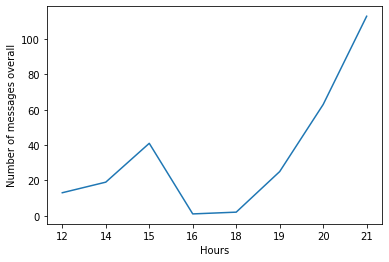

In [33]:
# Ploting data

lists = sorted(plot_data.items())
x, y = zip(*lists)


plt.plot(x, y)
plt.xlabel('Hours')
plt.ylabel('Number of messages overall')
plt.show()


In [ ]:
# TODO: add same plot for all dialogs
# add titels to the plots